<a href="https://colab.research.google.com/github/nguyetvo/Nguyet-ML2-Online-042020/blob/master/Transfer_Learning_using_Inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-05-05 16:28:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 2404:6800:4008:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  92.7MB/s    in 0.7s    

2020-05-05 16:28:39 (92.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
#Import Libraries

import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [0]:
# Create the respective directories

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

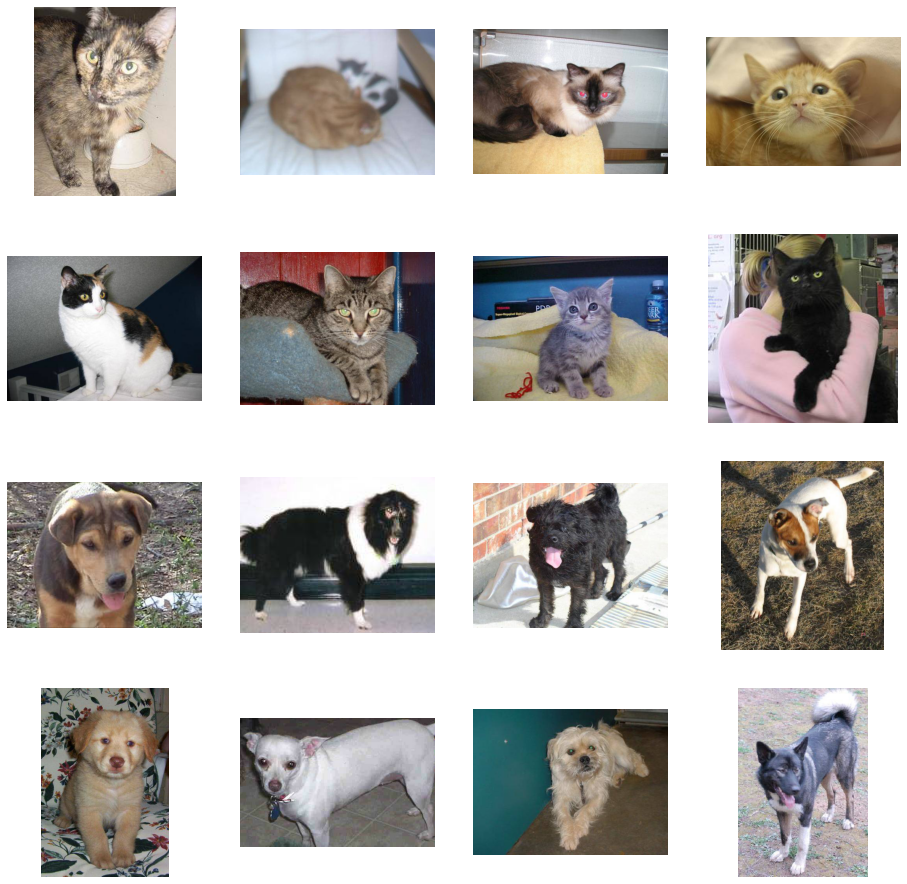

In [4]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

**Import the Inception model**

I am going to use all the layers in the model except for the last fully connected layer as it is specific to the ImageNet competition.

In [0]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [6]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


Make all the layers non trainable (can retrain some of the lower layers to increase performance. This may lead to overfitting)

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

Define a Callback class that stops training once accuracy reaches 95%

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

I use binary_crossentropy as the loss metric as I have 2 target classes (it's a binary classification problem)

My optimizer is RMSprop with a learning rate of 0.0001 (I can experiment with this; Adam and Adagrad optimizers would also work well)

In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

**Rescale the Images**

The data generators read pictures in source folders, convert them to float32 tensors, and feed them (with their labels) to a network. I'll have one generator for the training images and one for the validation images.

Input data to the neural networks should be normalized to aid in processing. I will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit_generator, evaluate_generator, and predict_generator.

I also perform Image Augmentation where I change the images a bit by rotating them, squashing them, etc.
I can implement this using the ImageDataGenerator Class

train_datagen = ImageDataGenerator(rescale = 1./255.,

                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

Some options that are available:
-  rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- shear_range is for randomly applying shearing transformations
- zoom_range is for randomly zooming inside pictures
- horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures)
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Flow images in batches of 20 using train _datagen and test_datagen

In [10]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 50,
            validation_steps = 25,
            verbose = 2,
            callbacks=[callbacks])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
50/50 - 13s - loss: 1.7682 - acc: 0.8330 - val_loss: 0.7508 - val_acc: 0.7960
Epoch 2/50
50/50 - 11s - loss: 0.5460 - acc: 0.8790 - val_loss: 0.3626 - val_acc: 0.9280
Epoch 3/50
50/50 - 11s - loss: 0.4551 - acc: 0.8760 - val_loss: 0.1556 - val_acc: 0.9460
Epoch 4/50
50/50 - 11s - loss: 0.4107 - acc: 0.8970 - val_loss: 0.1343 - val_acc: 0.9560
Epoch 5/50
50/50 - 12s - loss: 0.3712 - acc: 0.9010 - val_loss: 0.2312 - val_acc: 0.9260
Epoch 6/50
50/50 - 11s - loss: 0.3869 - acc: 0.9080 - val_loss: 0.7538 - val_acc: 0.8620
Epoch 7/50
50/50 - 11s - loss: 0.4408 - acc: 0.8890 - val_loss: 0.3359 - val_acc: 0.9180
Epoch 8/50
50/50 - 11s - loss: 0.3313 - acc: 0.9220 - val_loss: 0.0947 - val_acc: 0.9600
Epoch 9/50
50/50 - 12s - loss: 0.3553 - acc: 0.9010 - val_loss: 0.2688 - val_acc: 0.9380
Epoch 10/50
50/50 - 11s - loss: 0.3352 - acc: 0.9110 - val_loss: 0.2425 - val_acc: 0.9340
Epoch 11/50
50/50 - 11s - loss: 0

This is the kind of result I were hoping for using Transfer Learning; Building upon a pre-trained model and using it in custom application which was able to achieve great performance after training on just 2000 images.

**Plot Accuracy and Loss**

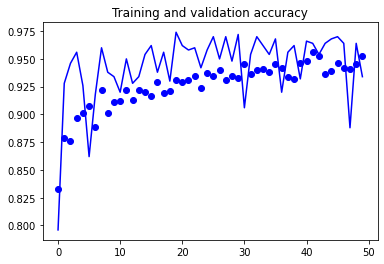

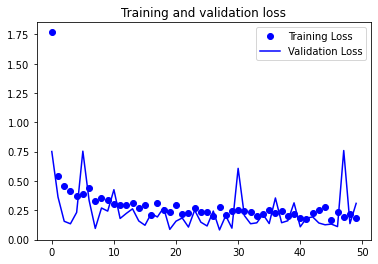

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

An approach where I do not use all the layers in the pre-trained model

In [13]:
last_layer = pre_trained_model.get_layer('mixed7') #Only use layers including and above 'mixed7'
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [14]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

callbacks = myCallback()

history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 50,
            validation_steps = 25,
            verbose = 2,
            callbacks=[callbacks])

last layer output shape:  (None, 7, 7, 768)
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50
50/50 - 12s - loss: 0.4497 - acc: 0.8440 - val_loss: 0.1632 - val_acc: 0.9320
Epoch 2/50
50/50 - 11s - loss: 0.2636 - acc: 0.8890 - val_loss: 0.1938 - val_acc: 0.9300
Epoch 3/50
50/50 - 12s - loss: 0.2190 - acc: 0.9120 - val_loss: 0.1505 - val_acc: 0.9500
Epoch 4/50
50/50 - 11s - loss: 0.2216 - acc: 0.9170 - val_loss: 0.1507 - val_acc: 0.9420
Epoch 5/50
50/50 - 11s - loss: 0.2131 - acc: 0.9140 - val_loss: 0.2257 - val_acc: 0.9420
Epoch 6/50
50/50 - 11s - loss: 0.2038 - acc: 0.9220 - val_loss: 0.0947 - val_acc: 0.9660
Epoch 7/50
50/50 - 11s - loss: 0.2035 - acc: 0.9240 - val_loss: 0.1356 - val_acc: 0.9460
Epoch 8/50
50/50 - 11s - loss: 0.1550 - acc: 0.9380 - val_loss: 0.1124 - val_acc: 0.9640
Epoch 9/50
50/50 - 11s - loss: 0.1686 - acc: 0.9420 - val_loss: 0.1913 - val_acc: 0.9380
Epoch 10/50
50/50 - 11s - loss: 0.2258 - acc: 0.9210 - val_loss: 0.0975

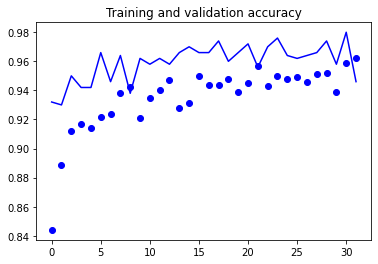

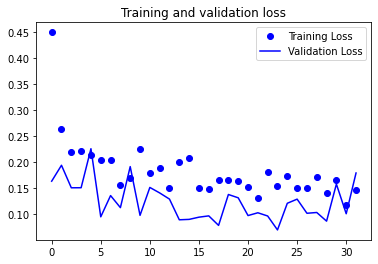

In [15]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Test with custom images

In [21]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving 15.jpg to 15.jpg
[0.]
15.jpg is a cat


In [23]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving 21.jpg to 21 (1).jpg
[0.]
21.jpg is a cat


#**A report with different ways of fine-tune/transfer learning of the trained model.**


**MobileNet**



**Create the base model from the pre-trained convnets**

- Create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe.

- First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

- First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

**Feature extraction**

- In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

*Freeze the convolutional base*

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

**Fine tuning**

- In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

- One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

- Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

**Un-freeze the top layers of the model**

-All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

**Summary:**

- **Using a pre-trained model for feature extraction:** When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

- **Fine-tuning a pre-trained model:** To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

**Inception-v3**

*Fine-tune Inception-V3.*

#The code for fine-tuning Inception-V3.


```
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K

from sklearn.metrics import log_loss

from load_cifar10 import load_cifar10_data

def conv2d_bn(x, nb_filter, nb_row, nb_col,
              border_mode='same', subsample=(1, 1),
              name=None):
    """
    Utility function to apply conv + BN for Inception V3.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    bn_axis = 1
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample,
                      activation='relu',
                      border_mode=border_mode,
                      name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name)(x)
    return x

def inception_v3_model(img_rows, img_cols, channel=1, num_classes=None):
    """
    Inception-V3 Model for Keras
    Model Schema is based on 
    https://github.com/fchollet/deep-learning-models/blob/master/inception_v3.py
    ImageNet Pretrained Weights 
    https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_th_dim_ordering_th_kernels.h5
    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_classes - number of class labels for our classification task
    """
    channel_axis = 1
    img_input = Input(shape=(channel, img_rows, img_cols))
    x = conv2d_bn(img_input, 32, 3, 3, subsample=(2, 2), border_mode='valid')
    x = conv2d_bn(x, 32, 3, 3, border_mode='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, border_mode='valid')
    x = conv2d_bn(x, 192, 3, 3, border_mode='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0, 1, 2: 35 x 35 x 256
    for i in range(3):
        branch1x1 = conv2d_bn(x, 64, 1, 1)

        branch5x5 = conv2d_bn(x, 48, 1, 1)
        branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

        branch3x3dbl = conv2d_bn(x, 64, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), border_mode='same')(x)
        branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
        x = merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                  mode='concat', concat_axis=channel_axis,
                  name='mixed' + str(i))

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, subsample=(2, 2), border_mode='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3,
                             subsample=(2, 2), border_mode='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = merge([branch3x3, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), border_mode='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                  mode='concat', concat_axis=channel_axis,
                  name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 160, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          subsample=(2, 2), border_mode='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 3, 3,
                            subsample=(2, 2), border_mode='valid')

    branch_pool = AveragePooling2D((3, 3), strides=(2, 2))(x)
    x = merge([branch3x3, branch7x7x3, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = merge([branch3x3_1, branch3x3_2],
                          mode='concat', concat_axis=channel_axis,
                          name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = merge([branch3x3dbl_1, branch3x3dbl_2],
                             mode='concat', concat_axis=channel_axis)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), border_mode='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = merge([branch1x1, branch3x3, branch3x3dbl, branch_pool],
                  mode='concat', concat_axis=channel_axis,
                  name='mixed' + str(9 + i))

    # Fully Connected Softmax Layer
    x_fc = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(x)
    x_fc = Flatten(name='flatten')(x_fc)
    x_fc = Dense(1000, activation='softmax', name='predictions')(x_fc)

    # Create model
    model = Model(img_input, x_fc)

    # Load ImageNet pre-trained data 
    model.load_weights('imagenet_models/inception_v3_weights_th_dim_ordering_th_kernels.h5')

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(x)
    x_newfc = Flatten(name='flatten')(x_newfc)
    x_newfc = Dense(num_classes, activation='softmax', name='predictions')(x_newfc)

    # Create another model with our customized softmax
    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model 

if __name__ == '__main__':

    # Example to fine-tune on 3000 samples from Cifar10

    img_rows, img_cols = 299, 299 # Resolution of inputs
    channel = 3
    num_classes = 10 
    batch_size = 16 
    nb_epoch = 10

    # Load Cifar10 data. Please implement your own load_data() module for your own dataset
    X_train, Y_train, X_valid, Y_valid = load_cifar10_data(img_rows, img_cols)

    # Load our model
    model = inception_v3_model(img_rows, img_cols, channel, num_classes)

    # Start Fine-tuning
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_data=(X_valid, Y_valid),
              )

    # Make predictions
    predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

    # Cross-entropy loss score
    score = log_loss(Y_valid, predictions_valid)
```



The model is characterized by the usage of the Inception Module, which is a concatenation of features maps generated by kernels of varying dimensions.

The process is mostly similar to that of VGG16, with one subtle difference. Inception-V3 does not use Keras’ Sequential Model due to branch merging (for the inception module), hence we cannot simply use model.pop() to truncate the top layer.

Instead, after we create the model and load it up with the ImageNet weight, we perform the equivalent of top layer truncation by defining another fully connected sofmax (x_newfc) on top of the last inception module (x). This is done using the following snippet:





```
# Last Inception Module 
x = merge([branch1x1, branch3x3, branch3x3dbl, branch_pool],
                  mode='concat', concat_axis=channel_axis,
                  name='mixed' + str(9 + i))

# Fully Connected Softmax Layer
x_fc = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(x)
x_fc = Flatten(name='flatten')(x_fc)
x_fc = Dense(1000, activation='softmax', name='predictions')(x_fc)

# Create model
model = Model(img_input, x_fc)

# Load ImageNet pre-trained data
model.load_weights('cache/inception_v3_weights_th_dim_ordering_th_kernels.h5')

# Truncate and replace softmax layer for transfer learning
# Cannot use model.layers.pop() since model is not of Sequential() type
# The method below works since pre-trained weights are stored in layers but not in the model
x_newfc = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(x)
x_newfc = Flatten(name='flatten')(x_newfc)

# Create another model with our customized softmax
model = Model(img_input, x_newfc)

# Learning rate is changed to 0.001
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model = inception_v3_model(img_rows, img_cols, channel, num_class)
```

